In [1]:
#loading packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings 
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder


In [2]:
na_values = ["unknown"]

df = pd.read_csv('base_train.csv',
                 na_values=na_values,
                 sep=',')

In [3]:
print(f"Cantidad de filas : {df.shape[0]}")
print(f"Cantidad de columnas : {df.shape[1]}")

Cantidad de filas : 31478
Cantidad de columnas : 21


In [4]:
def plot_dist(val):
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

    # assigning a graph to each ax
    sns.boxplot(x =val, ax=ax_box)
    sns.distplot(val, ax=ax_hist)
    plt.show()
    
    


In [5]:
((df.isnull().sum() / len(df))*100).sort_values(ascending = False).to_frame()

,0
INCUMPLIMIENTO,20.859013
EDUCACION,4.177521
VIVIENDA,2.344495
PRESTAMO,2.344495
TRABAJO,0.806913
ESTADO_CIVIL,0.196963
ID,0.000000
TASA_VAR_EMP,0.000000
MONTO_TRANSAC,0.000000
MONTO_DEUDA,0.000000


- tendremos que tratar con los missings de unas pocas variables

#### EDAD

- tenemos valores outliers en la variable edad, valore mayores a 65 y menores a 21. Por el momento se desconoce el origen de esto ya que puede ser por error humano, casos muy atipicos o mal llenado de informacion del cliente. En esta situacion al ser pocos los valores con errores se optará por eliminar estas observaciones con el fin de no alterar la distribución con inputacion del promedio o mediana.

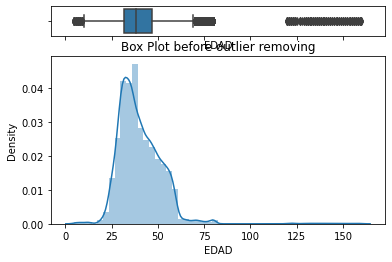

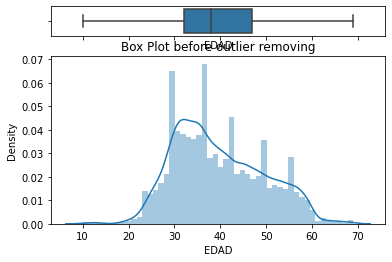

In [6]:
for i in ['EDAD']:
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

# assigning a graph to each ax
    sns.boxplot(x =df[i], ax=ax_box)
    sns.distplot(df[i], ax=ax_hist)
    plt.title("Box Plot before outlier removing")
    plt.show()
    def drop_outliers(df, field_name):
        iqr = 1.5 * (np.percentile(df[field_name], 75) - np.percentile(df[field_name], 25))
        df.drop(df[df[field_name] > (iqr + np.percentile(df[field_name], 75))].index, inplace=True)
        df.drop(df[df[field_name] < (np.percentile(df[field_name], 25) - iqr)].index, inplace=True)
    drop_outliers(df, i)
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

# assigning a graph to each ax
    sns.boxplot(x =df[i], ax=ax_box)
    sns.distplot(df[i], ax=ax_hist)
    plt.title("Box Plot before outlier removing")
    plt.show()

#### trabajo

In [7]:
#imputamos con la moda ya que son pocos missings 
# Imputamos la variable TRABAJO con la moda
df['TRABAJO'].fillna(df['TRABAJO'].mode()[0], inplace=True)
print("Valores perdidos en TRABAJO: " + 
      str(df['TRABAJO'].isnull().sum()))

Valores perdidos en TRABAJO: 0


- Ya que no hay un orden distinguible para cada trabajo, dividiremos por ingresos o no ingresos.

In [8]:
df.TRABAJO.value_counts().to_dict()

{'admin.': 8145,
 'blue-collar': 7059,
 'technician': 5121,
 'services': 2998,
 'management': 2216,
 'self-employed': 1099,
 'entrepreneur': 1096,
 'retired': 994,
 'housemaid': 791,
 'unemployed': 764,
 'student': 632}

In [9]:
#1 para los trabajos que no generan ingresos
def clas_work(x):
    if x  in ['student','unemployed','retired']:
        return 0
    else:
        return 1

In [10]:
df['TRABAJO'] = df.TRABAJO.apply(clas_work)

In [11]:
df.groupby('TRABAJO').ACEPTACION.count().sort_values(ascending=False)

TRABAJO
1    28525
0     2390
Name: ACEPTACION, dtype: int64

In [12]:
df['TRABAJO'] = df.groupby('TRABAJO')['ID'].transform('count').astype('int')

In [13]:
df.groupby('TRABAJO').ACEPTACION.mean().sort_values(ascending=False)

TRABAJO
2390     0.203347
28525    0.099702
Name: ACEPTACION, dtype: float64

In [14]:
df.groupby('TRABAJO').INGRESO .median().sort_values(ascending=False)

TRABAJO
2390     1943.807985
28525    1484.228462
Name: INGRESO, dtype: float64

In [15]:
df['TRABAJO'] = df.groupby('TRABAJO')['ID'].transform('count').astype('int')

#### ESTADO CIVIL

In [16]:
# Imputamos la variable ESTADO_CIVIL con la moda
df['ESTADO_CIVIL'].fillna(df['ESTADO_CIVIL'].mode()[0], inplace=True)
print("Valores perdidos en ESTADO_CIVIL: " + 
      str(df['ESTADO_CIVIL'].isnull().sum()))

Valores perdidos en ESTADO_CIVIL: 0


In [17]:
df = df.replace({'ESTADO_CIVIL':{' married':'married', 'marrid': 'married','singgle ':'single'
                            ,'single ': 'single', 'divorced ':'divorced','d_ivorced': 'divorced'}})

In [18]:
df.ESTADO_CIVIL.value_counts()

married     18802
single       8730
divorced     3383
Name: ESTADO_CIVIL, dtype: int64

In [19]:
df.groupby('ESTADO_CIVIL').ACEPTACION.mean()

ESTADO_CIVIL
divorced    0.091339
married     0.096160
single      0.138946
Name: ACEPTACION, dtype: float64

In [20]:
pd.get_dummies(df['ESTADO_CIVIL'], drop_first=True)


,married,single
0,0,1
1,0,1
2,1,0
3,0,0
4,1,0
...,...,...
31473,0,1
31474,0,0
31475,0,1
31476,1,0


In [21]:
df = pd.concat([df.drop(columns='ESTADO_CIVIL', axis=1),pd.get_dummies(df['ESTADO_CIVIL'], drop_first=True)], axis=1)

#### EDUCACION

In [22]:
df['EDUCACION'].isnull().sum()

1272

In [23]:
# Imputamos la variable EDUCACION con la moda
df['EDUCACION'].fillna(df['EDUCACION'].mode()[0], inplace=True)
print("Valores perdidos en EDUCACION: " + 
      str(df['EDUCACION'].isnull().sum()))

Valores perdidos en EDUCACION: 0


In [24]:
df['EDUCACION'] = df.EDUCACION.replace({'illiterate': 'basic','basic.6y': 'basic','basic.4y':'basic','basic.9y':'basic','unknown':np.nan})



In [25]:
df.EDUCACION.value_counts().to_dict()

{'university.degree': 10424,
 'basic': 9355,
 'high.school': 7159,
 'professional.course': 3977}

In [26]:
df['EDUCACION'] = df['EDUCACION'].replace({'basic':1,'high.school': 2 ,'professional.course':3, 'university.degree':4 })

---

#### INCUMPLIMIENTO 

In [27]:
df.INCUMPLIMIENTO.isna().sum()

6498

In [28]:
df.INCUMPLIMIENTO.value_counts()

no     24414
yes        3
Name: INCUMPLIMIENTO, dtype: int64

<AxesSubplot:xlabel='ACEPTACION', ylabel='count'>

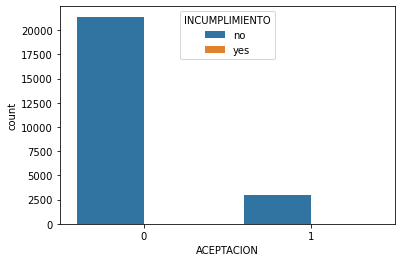

In [29]:
sns.countplot(x=df.ACEPTACION, hue=df.INCUMPLIMIENTO)

In [30]:
# Eliminamos esta variable debido a que no generara impacto en uno de sus segmentos por tener información insuficiente
df.drop(['INCUMPLIMIENTO'], axis=1, inplace=True)

#### VIVIENDA 

In [31]:
df.VIVIENDA.isna().sum()

727

In [32]:

df.VIVIENDA.value_counts()

yes    16199
no     13989
Name: VIVIENDA, dtype: int64

In [33]:
# Imputamos la variable VIVIENDA con la moda
df['VIVIENDA'].fillna(df['VIVIENDA'].mode()[0], inplace=True)
print("Valores perdidos en VIVIENDA: " + 
      str(df['VIVIENDA'].isnull().sum()))

Valores perdidos en VIVIENDA: 0


<AxesSubplot:xlabel='ACEPTACION', ylabel='count'>

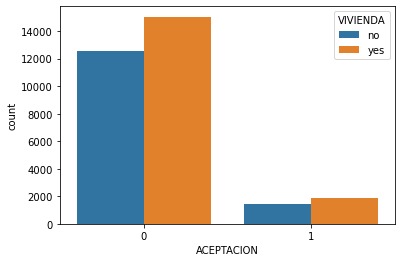

In [34]:
sns.countplot(x=df.ACEPTACION, hue=df.VIVIENDA)

#### PRESTAMO 

In [35]:
df.PRESTAMO.value_counts()

no     25533
yes     4655
Name: PRESTAMO, dtype: int64

In [36]:
df.PRESTAMO.isna().sum()

727

In [37]:
# Imputamos la variable PRESTAMO con la moda
df['PRESTAMO'].fillna(df['PRESTAMO'].mode()[0], inplace=True)
print("Valores perdidos en PRESTAMO: " + 
      str(df['PRESTAMO'].isnull().sum()))

Valores perdidos en PRESTAMO: 0


<AxesSubplot:xlabel='ACEPTACION', ylabel='count'>

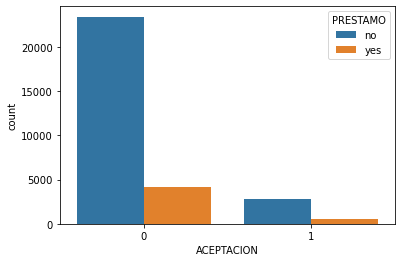

In [38]:
sns.countplot(x=df.ACEPTACION, hue=df.PRESTAMO)

#### TIPO_CONTACTO 

In [39]:
df.TIPO_CONTACTO.value_counts().to_dict()

{'cellular': 19511, 'telephone': 11404}

In [40]:
df['TIPO_CONTACTO'] = df.TIPO_CONTACTO.replace({'cellular':1,'telephone':0})

#### MES 

In [41]:
df['MES'] = df['MES'].replace(
    {'may': 5,
 'sep': 9,
 'oct': 10,
 'jun': 6,
 'nov': 11,
 'apr': 4,
 'aug': 8,
 'jul': 7,
 'mar': 3,
 'dec': 12}    
)

#### CAMPANA 

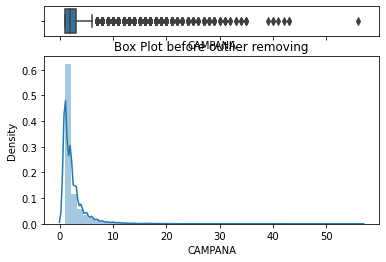

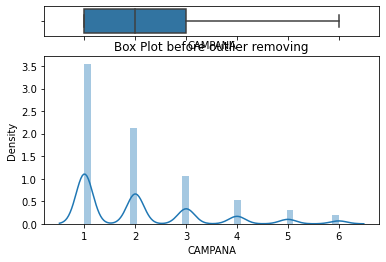

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
for i in ['CAMPANA']:
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

# assigning a graph to each ax
    sns.boxplot(x =df[i], ax=ax_box)
    sns.distplot(df[i], ax=ax_hist)
    plt.title("Box Plot before outlier removing")
    plt.show()
    def drop_outliers(df, field_name):
        iqr = 1.5 * (np.percentile(df[field_name], 75) - np.percentile(df[field_name], 25))
        df.drop(df[df[field_name] > (iqr + np.percentile(df[field_name], 75))].index, inplace=True)
        df.drop(df[df[field_name] < (np.percentile(df[field_name], 25) - iqr)].index, inplace=True)
    drop_outliers(df, i)
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

# assigning a graph to each ax
    sns.boxplot(x =df[i], ax=ax_box)
    sns.distplot(df[i], ax=ax_hist)
    plt.title("Box Plot before outlier removing")
    plt.show()